In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import utils
import tqdm


device = 'cpu'
dtype = torch.float64

In [ ]:
inputs = pd.read_csv('top_inputs.csv')
outputs = pd.read_csv('top_outputs.csv')


In [ ]:
X = torch.tensor(inputs.values)
y = torch.tensor(outputs.values)


In [ ]:
import win32com.client
import os

def SuperPro2(p, space):

    p = unnormalize_x(p, space)
    p = p.reshape(-1,1).numpy()

    excelObject = win32com.client.Dispatch("Excel.Application")  #instantiate excel app
    excelObject.Visible = True
    temp1= os.getcwd()+'\\pDNA.xlsm'

    
    wb = excelObject.Workbooks.Open(temp1)

    excelObject.Application.Run('BeforeSuperExcelMatlab')

    temp3 =np.shape(p)[1]
    F =np.zeros((8,1,temp3))
    for i in range(temp3):
        

        #temp4 = excelObject.Application.Run('SuperExcelMatlab', p[0,i], p[1,i], p[2,i], p[3,i], p[4,i], p[5,i], p[6,i], p[7,i], 
                                            #p[8,i], p[9,i], p[10,i], p[11,i], np.round(p[12,i]), p[13,i], p[14,i], np.round(p[15,i]), p[16,i], p[17,i])
                                            
        temp4 = excelObject.Application.Run('SuperExcelMatlab', 43200, p[0,i], 0.0033, p[1,i], 0.95, p[2,i], p[3,i], p[4,i], 
                                            p[5,i], 150, p[6,i], 0.03, np.round(p[7,i]), 0.003, 0.02, np.round(p[8,i]), p[9,i], 0.05)
        
        
        #temp4 = excelObject.Application.Run('SuperExcelMatlab', 43200, 108000, 0.0033, 0.02045, 0.95, 144000, 0.038175, 0.204507, 
                                            #0.98, 150, 0.578072, 0.03, np.round(50), 0.003, 0.02, np.round(40), 0.001333, 0.05)

        F[0,0,i] = temp4[0] # Formulation concentration (kg/m3)
        F[1,0,i] = temp4[1] #  Productivity (kg/batch)
        F[2,0,i] = temp4[2] # CAPEX ($)
        F[3,0,i] = temp4[3]/temp4[4] # OPEX ($/batch)
        F[4,0,i] = temp4[4] # Number of batches (batches/y)
        F[5,0,i] = temp4[5] # Batch time (s)
        F[6,0,i] = temp4[6] # Cycle time (s)
        F[7,0,i] = temp4[3]/(temp4[4]*(temp4[1]/0.001)) # Cost per gram ($/g)
        #F[7,0,i] = temp4[3]/temp4[4] # Opex per batch ($/batch)
        

    excelObject.Application.Run('AfterSuperExcelMatlab')
    
    wb.Close(False)
    excelObject.Application.Quit()

    
    return torch.from_numpy(F[3,0,:]).unsqueeze(-1)

In [6]:
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_model
from gpytorch.kernels import MaternKernel, RBFKernel
from botorch.models.transforms import Standardize



def initialize_model(X, y, GP=None, state_dict=None, *GP_args, **GP_kwargs):
    """
    Create GP model and fit it. The function also accepts
    state_dict which is used as an initialization for the GP model.
    
    Parameters
    ----------
    X : torch.tensor, shape=(n_samples, dim)
        Input values
        
    y : torch.tensor, shape=(n_samples,)
        Output values
        
    GP : botorch.models.Model
        GP model class
        
    state_dict : dict
        GP model state dict
        
    Returns
    -------
    mll : gpytorch.mlls.MarginalLoglikelihood
        Marginal loglikelihood
    
    gp : 
    """

    covar_module = MaternKernel(nu=2.5)


    if GP is None:
        GP = SingleTaskGP
        
    model = GP(X, y,  outcome_transform=Standardize(1), covar_module = covar_module, *GP_args, **GP_kwargs).to(X)

    mll = ExactMarginalLogLikelihood(model.likelihood, model)

    # load state dict if it is passed
    if state_dict is not None:
        model.load_state_dict(state_dict)
    return mll, model

In [ ]:
#6. Repeat from step 1
from botorch.optim import optimize_acqf
def bo_step(X, y, objective, bounds, GP=None, acquisition=None, q=1, state_dict=None, plot=False):

    
    if y is not None:
        mll, gp = initialize_model(X, y, GP=GP, state_dict=state_dict)
        fit_gpytorch_model(mll)
    
    # Create acquisition function
    acquisition = acquisition(gp)
    inequality_constraints = [(torch.tensor([0, 1]), torch.tensor([-1, 1], dtype=torch.float64), torch.tensor(0.0, dtype=torch.float64)),
    (torch.tensor([1, 5]), torch.tensor([-1, 1], dtype=torch.float64), torch.tensor(0, dtype=torch.float64))]
    # Optimize acquisition function if y is not None
    if y is not None:
        candidate = optimize_acqf(
            acquisition, bounds=bounds, q=q,  inequality_constraints=None, num_restarts=50, raw_samples=1024,
        )
       
        # Check if objective is not None before updating y
        y_new = objective(candidate[0].squeeze())
        print('y_new=', y_new)
        if y_new is not None:
            y = torch.cat([y, y_new])
            X = torch.cat([X, candidate[0]])
        else: 
            # Repeat until y_random is not None
            while True:
                X_random = torch.rand(18)
                y_rand = objective(X_random)
                if y_rand is not None:
                    break
            X = torch.cat([X, X_random.unsqueeze(0)])
            y = torch.cat([y, y_rand])

    if plot:
        utils.plot_acquisition(acquisition, X, y, candidate)
        
    return X, y, gp

In [8]:
from botorch.utils.transforms import normalize, unnormalize

def normalize_x(params, space):
    bounds = torch.tensor([var['domain'] for var in space]).to(params).t()
    params = normalize(params, bounds)
    return params

def unnormalize_x(params, space):
    bounds = torch.tensor([var['domain'] for var in space]).to(params).t()
    params = unnormalize(params, bounds)
    return params

def wrap_X(X, space):
    """
    Wrap tensor to a list of dictionaries
    
    Parameters:
    X : torch.tensor, shape=(n_samples, dim)
        Tensor of parameters values
        
    space : dict
        Search space description
        
    Returns
    -------
    wrapped_X : lsit[dict{param_name: value}]
        List of dictionary of parameters
    """
    def _wrap_row(row):
        wrapped_row = {}
        for i, x in enumerate(row):
            wrapped_row[space[i]['name']] = x.item()
        
            if space[i]['type'] == 'discrete':
                wrapped_row[space[i]['name']] = int(np.round(x.item()))
        return wrapped_row
    
    wrapped_X = []
    for i in range(X.shape[0]):
        wrapped_X.append(_wrap_row(X[i]))
        
    return wrapped_X


def unwrap_X(parameters, space):
    """
    Unwrap list of dictionaries to torch.tensor
    
    Parameters
    ----------
    parameters : list(dict)
        List of parameters
        
    space : dict
        Input space definition
        
    Returns
    -------
    unwrapped_X : torch.tensor
        Tensor of parameter values
    """
    X = torch.zeros(len(parameters), len(space),
                    dtype=torch.float64)
    for i, p in enumerate(parameters):
        x = [p[var['name']] for var in space]
        X[i] = torch.tensor(x, dtype=torch.float64)
        
    return X




def superpro(parameters,space):


    #Objective function

    score = SuperPro2(parameters,space)

    print(score) 

    return score

In [ ]:

from botorch.utils.sampling import draw_sobol_samples
# Define the region

space = [
    #{'name': 'flask_time', 'type': 'continuous', 'domain': (21600, 108000)},
    {'name': 'seed_time', 'type': 'continuous', 'domain': (43200, 108000)},
    #{'name': 'fed_batch_seed', 'type': 'continuous', 'domain': (0.001636, 0.004908)},
    {'name': 'batch_seed', 'type': 'continuous', 'domain': (0.010225325, 0.030675975)},
    #{'name': 'conversion_seed', 'type': 'continuous', 'domain': (0.9, 0.98)},
    {'name': 'main_time', 'type': 'continuous', 'domain': (64800, 144000)},
    {'name': 'fed_batch', 'type': 'continuous', 'domain': (0.0190875, 0.0572625)},
    {'name': 'batch_med', 'type': 'continuous', 'domain': (0.102253255, 0.306759765)},
    {'name': 'conversion_main', 'type': 'continuous', 'domain': (0.9, 0.98)},
    #{'name': 'solid_conc', 'type': 'continuous', 'domain': (50, 300)},
    {'name': 'res_vol', 'type': 'continuous', 'domain': (0.28903585,  0.86710755)},
    #{'name': 'equi1', 'type': 'continuous', 'domain': (0.01, 0.05)},
    {'name': 'dia1', 'type': 'discrete', 'domain': (10, 50)},
    #{'name': 'flush1', 'type': 'continuous', 'domain': (0.0015,  0.0045)},
    #{'name': 'equi2', 'type': 'continuous', 'domain': (0.01, 0.05)},
    {'name': 'dia2', 'type': 'discrete', 'domain': (10, 50)},
    {'name': 'flush2', 'type': 'continuous', 'domain': (0.00067,  0.002)},
    #{'name': 'failure', 'type': 'continuous', 'domain': (0,  0.1)},
]


bounds_01 = torch.zeros(2, len(space), dtype=torch.float64)
bounds_01[1] = 1

init_X = draw_sobol_samples(bounds_01, 6, 1).squeeze()

init_y = []
valid_init_X = []

while len(init_y) < 5:
    for i in range(len(init_X)):
        result = superpro(init_X[i], space)
        if result is not None:
            init_y.append(result)
            valid_init_X.append(init_X[i])
    
    # If len(init_y) is still less than 5, generate additional Sobol samples
    if len(init_y) < 5:
        additional_samples = draw_sobol_samples(bounds_01, 5 - len(init_y), 1).squeeze()
        init_X = torch.cat([init_X, additional_samples])


tensor([[253135.1286]], dtype=torch.float64)
init_X[i] tensor([0.7143, 0.4366, 0.6404, 0.5669, 0.8588, 0.8068, 0.2343, 0.7409, 0.6875,
        0.9793], dtype=torch.float64)
1
tensor([[162154.4525]], dtype=torch.float64)
init_X[i] tensor([0.0418, 0.9373, 0.0711, 0.1140, 0.0252, 0.0742, 0.8855, 0.4680, 0.3439,
        0.2776], dtype=torch.float64)
2
tensor([[194628.3178]], dtype=torch.float64)
init_X[i] tensor([0.3962, 0.0744, 0.8732, 0.8651, 0.3239, 0.3481, 0.4180, 0.0904, 0.0994,
        0.2048], dtype=torch.float64)
3
tensor([[220651.6413]], dtype=torch.float64)
init_X[i] tensor([0.8477, 0.5752, 0.4308, 0.3182, 0.5596, 0.5212, 0.6965, 0.8643, 0.9319,
        0.5383], dtype=torch.float64)
4
tensor([[201619.5809]], dtype=torch.float64)
init_X[i] tensor([0.9414, 0.1265, 0.2300, 0.4501, 0.7064, 0.9164, 0.2984, 0.2336, 0.1888,
        0.4655], dtype=torch.float64)
5
tensor([[253289.2598]], dtype=torch.float64)
init_X[i] tensor([0.3025, 0.6263, 0.5435, 0.9969, 0.4119, 0.2146, 0.5827, 0.9442

In [10]:
init_y2= torch.tensor(init_y)
init_y2= init_y2.reshape(-1,1)
init_X2 = torch.stack(valid_init_X)


In [11]:


init_X2 = torch.cat([normalize_x(X, space), init_X2])

init_y2 = torch.cat([y, init_y2])

In [12]:

def get_best_params(params, scores, space):
    bounds = torch.tensor([var['domain'] for var in space]).to(params).t()
    params = unnormalize(params, bounds)
    
    best_idx = np.argmin(scores.cpu().numpy())
    
    return wrap_X(params[[best_idx]], space)[0]

In [ ]:
from botorch.acquisition import (ExpectedImprovement, PosteriorMean,
                                 ProbabilityOfImprovement,
                                 UpperConfidenceBound, qKnowledgeGradient)
from botorch.acquisition.max_value_entropy_search import qMaxValueEntropy
from botorch.sampling import SobolQMCNormalSampler
from botorch.acquisition.max_value_entropy_search import qMaxValueEntropy
import cProfile
import pstats
import time

start_time = time.time()
cum_best_df = pd.DataFrame()
best_params_df = pd.DataFrame()

for i in range(0, 10,10) :
    print('Seed:', i, 'out of 100')
    torch.manual_seed(i)



    params = init_X2

    scores = init_y2

    state_dict = None

    budget = 116

    objective = lambda x: superpro(x, space)

    # Initialize the counter for consecutive iterations without improvement
    no_improvement_count = 0
    consecutive_iterations_threshold = 20  # Threshold for consecutive iterations without improvement

    best_score = float('+inf')  # Initialize the best score to a very low number

    with tqdm.tqdm(total=budget) as bar:
        while len(scores) < budget:
            n_samples = len(scores)
        
            # Assuming the rest of your optimization code goes here and updates `scores`
            GP = SingleTaskGP
        


        
            acquisition = lambda gp: UpperConfidenceBound(gp, beta=15, maximize=False)
        

            params, scores, gp = bo_step(params, scores, objective, bounds_01,
                                     GP=GP, acquisition=acquisition
                                     )

            current_best_score = scores.min().item()  # Get the current best score
        
            # Check if there is an improvement
            if current_best_score < best_score:
                best_score = current_best_score  # Update the best score
                no_improvement_count = 0  # Reset the counter since there was an improvement
            else:
                no_improvement_count += 1  # Increment the counter
        
            # Terminate if the number of consecutive iterations without improvement
            # reaches the threshold
            if no_improvement_count >= consecutive_iterations_threshold:
                print("Termination criterion met: No improvement for 20 consecutive iterations.")
                break  # Terminate the loop
        
            bar.update(len(scores) - n_samples)


            #print(scores)
        import sys

        cum_best = np.minimum.accumulate(scores.cpu().numpy())

        # Create a temporary DataFrame from `cum_best` and reindex `cum_best_df` to ensure it's long enough
        temp_df = pd.DataFrame({f'{i}': cum_best.squeeze()})
        cum_best_df = cum_best_df.reindex(index=range(max(len(cum_best_df), len(temp_df)))).assign(**temp_df)
        best_param = get_best_params(params, scores, space)
        best_param_values = list(best_param.values())
        best_params_df[f'{i}'] = pd.Series(best_param_values)

        np.set_printoptions(threshold=sys.maxsize)
        a= cum_best.squeeze()
        for j in range(len(a)):
            print(a[j])


end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Seed: 0 out of 100


  1%|          | 1/116 [00:13<26:29, 13.82s/it]

tensor([[127351.7353]], dtype=torch.float64)
y_new= tensor([[127351.7353]], dtype=torch.float64)


  2%|▏         | 2/116 [00:27<26:36, 14.00s/it]

tensor([[137966.6821]], dtype=torch.float64)
y_new= tensor([[137966.6821]], dtype=torch.float64)


  3%|▎         | 3/116 [00:42<26:27, 14.05s/it]

tensor([[137997.4207]], dtype=torch.float64)
y_new= tensor([[137997.4207]], dtype=torch.float64)


  3%|▎         | 4/116 [00:56<26:13, 14.05s/it]

tensor([[148974.2501]], dtype=torch.float64)
y_new= tensor([[148974.2501]], dtype=torch.float64)


  4%|▍         | 5/116 [01:09<25:39, 13.87s/it]

tensor([[124080.7179]], dtype=torch.float64)
y_new= tensor([[124080.7179]], dtype=torch.float64)


  5%|▌         | 6/116 [01:23<25:18, 13.81s/it]

tensor([[119455.2393]], dtype=torch.float64)
y_new= tensor([[119455.2393]], dtype=torch.float64)


  6%|▌         | 7/116 [01:36<24:55, 13.72s/it]

tensor([[131181.5640]], dtype=torch.float64)
y_new= tensor([[131181.5640]], dtype=torch.float64)


  7%|▋         | 8/116 [01:50<24:35, 13.66s/it]

tensor([[135515.6128]], dtype=torch.float64)
y_new= tensor([[135515.6128]], dtype=torch.float64)


  8%|▊         | 9/116 [02:03<24:18, 13.63s/it]

tensor([[146371.5665]], dtype=torch.float64)
y_new= tensor([[146371.5665]], dtype=torch.float64)


  9%|▊         | 10/116 [02:17<24:03, 13.61s/it]

tensor([[120067.8780]], dtype=torch.float64)
y_new= tensor([[120067.8780]], dtype=torch.float64)


  9%|▉         | 11/116 [02:31<23:47, 13.59s/it]

tensor([[130471.8666]], dtype=torch.float64)
y_new= tensor([[130471.8666]], dtype=torch.float64)


 10%|█         | 12/116 [02:44<23:31, 13.57s/it]

tensor([[129644.9617]], dtype=torch.float64)
y_new= tensor([[129644.9617]], dtype=torch.float64)


 11%|█         | 13/116 [02:59<23:55, 13.94s/it]

tensor([[161099.9319]], dtype=torch.float64)
y_new= tensor([[161099.9319]], dtype=torch.float64)


 12%|█▏        | 14/116 [03:13<23:34, 13.87s/it]

tensor([[151249.7589]], dtype=torch.float64)
y_new= tensor([[151249.7589]], dtype=torch.float64)


 13%|█▎        | 15/116 [03:27<23:47, 14.14s/it]

tensor([[143042.9141]], dtype=torch.float64)
y_new= tensor([[143042.9141]], dtype=torch.float64)


 14%|█▍        | 16/116 [03:41<23:18, 13.99s/it]

tensor([[139368.7745]], dtype=torch.float64)
y_new= tensor([[139368.7745]], dtype=torch.float64)


 15%|█▍        | 17/116 [03:55<22:54, 13.88s/it]

tensor([[134017.4995]], dtype=torch.float64)
y_new= tensor([[134017.4995]], dtype=torch.float64)


 16%|█▌        | 18/116 [04:08<22:32, 13.81s/it]

tensor([[142360.1955]], dtype=torch.float64)
y_new= tensor([[142360.1955]], dtype=torch.float64)


 16%|█▋        | 19/116 [04:22<22:17, 13.79s/it]

tensor([[145771.2071]], dtype=torch.float64)
y_new= tensor([[145771.2071]], dtype=torch.float64)


 17%|█▋        | 20/116 [04:36<21:58, 13.74s/it]

tensor([[120806.6810]], dtype=torch.float64)
y_new= tensor([[120806.6810]], dtype=torch.float64)


 18%|█▊        | 21/116 [04:49<21:40, 13.69s/it]

tensor([[151093.0108]], dtype=torch.float64)
y_new= tensor([[151093.0108]], dtype=torch.float64)


 19%|█▉        | 22/116 [05:03<21:28, 13.71s/it]

tensor([[135308.7470]], dtype=torch.float64)
y_new= tensor([[135308.7470]], dtype=torch.float64)


 20%|█▉        | 23/116 [05:17<21:11, 13.68s/it]

tensor([[121273.2927]], dtype=torch.float64)
y_new= tensor([[121273.2927]], dtype=torch.float64)


 21%|██        | 24/116 [05:30<20:55, 13.64s/it]

tensor([[157311.9584]], dtype=torch.float64)
y_new= tensor([[157311.9584]], dtype=torch.float64)


 22%|██▏       | 25/116 [05:44<20:42, 13.65s/it]

tensor([[116904.2723]], dtype=torch.float64)
y_new= tensor([[116904.2723]], dtype=torch.float64)


 22%|██▏       | 26/116 [05:58<20:31, 13.68s/it]

tensor([[128254.6149]], dtype=torch.float64)
y_new= tensor([[128254.6149]], dtype=torch.float64)


 23%|██▎       | 27/116 [06:11<20:18, 13.69s/it]

tensor([[117798.7193]], dtype=torch.float64)
y_new= tensor([[117798.7193]], dtype=torch.float64)


 24%|██▍       | 28/116 [06:25<20:00, 13.64s/it]

tensor([[117786.7059]], dtype=torch.float64)
y_new= tensor([[117786.7059]], dtype=torch.float64)


 25%|██▌       | 29/116 [06:38<19:43, 13.60s/it]

tensor([[118266.4834]], dtype=torch.float64)
y_new= tensor([[118266.4834]], dtype=torch.float64)


 26%|██▌       | 30/116 [06:52<19:35, 13.67s/it]

tensor([[122238.7941]], dtype=torch.float64)
y_new= tensor([[122238.7941]], dtype=torch.float64)


 27%|██▋       | 31/116 [07:06<19:19, 13.64s/it]

tensor([[119057.6378]], dtype=torch.float64)
y_new= tensor([[119057.6378]], dtype=torch.float64)


 28%|██▊       | 32/116 [07:19<19:08, 13.68s/it]

tensor([[135646.9325]], dtype=torch.float64)
y_new= tensor([[135646.9325]], dtype=torch.float64)


 28%|██▊       | 33/116 [07:33<18:53, 13.66s/it]

tensor([[139207.1345]], dtype=torch.float64)
y_new= tensor([[139207.1345]], dtype=torch.float64)


 29%|██▉       | 34/116 [07:47<18:37, 13.63s/it]

tensor([[120472.6046]], dtype=torch.float64)
y_new= tensor([[120472.6046]], dtype=torch.float64)


 30%|███       | 35/116 [08:00<18:24, 13.64s/it]

tensor([[124736.6601]], dtype=torch.float64)
y_new= tensor([[124736.6601]], dtype=torch.float64)


 31%|███       | 36/116 [08:14<18:13, 13.67s/it]

tensor([[123851.7558]], dtype=torch.float64)
y_new= tensor([[123851.7558]], dtype=torch.float64)


 32%|███▏      | 37/116 [08:28<17:59, 13.66s/it]

tensor([[123334.7060]], dtype=torch.float64)
y_new= tensor([[123334.7060]], dtype=torch.float64)


 33%|███▎      | 38/116 [08:41<17:45, 13.66s/it]

tensor([[124850.6100]], dtype=torch.float64)
y_new= tensor([[124850.6100]], dtype=torch.float64)


 34%|███▎      | 39/116 [08:55<17:31, 13.66s/it]

tensor([[125363.0529]], dtype=torch.float64)
y_new= tensor([[125363.0529]], dtype=torch.float64)


 34%|███▍      | 40/116 [09:09<17:15, 13.62s/it]

tensor([[118763.8664]], dtype=torch.float64)
y_new= tensor([[118763.8664]], dtype=torch.float64)


 35%|███▌      | 41/116 [09:22<17:00, 13.61s/it]

tensor([[119001.0350]], dtype=torch.float64)
y_new= tensor([[119001.0350]], dtype=torch.float64)


 36%|███▌      | 42/116 [09:37<17:12, 13.96s/it]

tensor([[118400.6257]], dtype=torch.float64)
y_new= tensor([[118400.6257]], dtype=torch.float64)


 37%|███▋      | 43/116 [09:51<16:52, 13.86s/it]

tensor([[116937.2945]], dtype=torch.float64)
y_new= tensor([[116937.2945]], dtype=torch.float64)


 38%|███▊      | 44/116 [10:04<16:32, 13.79s/it]

tensor([[120492.2001]], dtype=torch.float64)
y_new= tensor([[120492.2001]], dtype=torch.float64)


 38%|███▊      | 44/116 [10:18<16:51, 14.05s/it]

tensor([[119582.3297]], dtype=torch.float64)
y_new= tensor([[119582.3297]], dtype=torch.float64)
Termination criterion met: No improvement for 20 consecutive iterations.
150038.2643
150038.2643
150038.2643
150038.2643
150038.2643
150038.2643
150038.2643
150038.2643
150038.2643
150038.2643
150038.2643
150038.2643
150038.2643
150038.2643
150038.2643
150038.2643
127351.7353406761
127351.7353406761
127351.7353406761
127351.7353406761
124080.71792865843
119455.23934562795
119455.23934562795
119455.23934562795
119455.23934562795
119455.23934562795
119455.23934562795
119455.23934562795
119455.23934562795
119455.23934562795
119455.23934562795
119455.23934562795
119455.23934562795
119455.23934562795
119455.23934562795
119455.23934562795
119455.23934562795
119455.23934562795
119455.23934562795
119455.23934562795
116904.27231921421
116904.27231921421
116904.27231921421
116904.27231921421
116904.27231921421
116904.27231921421
116904.27231921421
116904.27231921421
116904.27231921421
116904.27231921

seed_time: 43200.0

batch_seed: 0.03067597560584545

main_time: 64800.0

fed_batch: 0.019087500870227814

batch_med: 0.102253258228302

conversion_main: 0.8999999761581421

res_vol: 0.2890358567237854

dia1: 10

dia2: 10

flush2: 0.0006699999794363976

Optimum 118373.70350390689


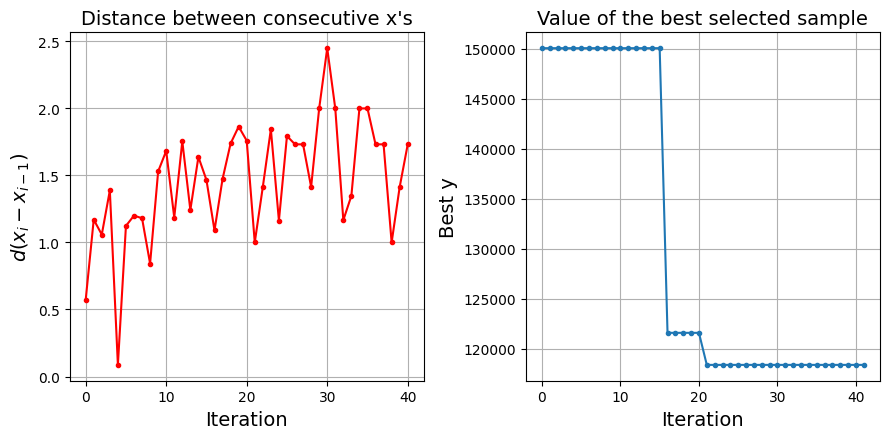

In [ ]:
#=============================================================RESULTS==============================================================
for key, value in best_param.items():
        print(f'{key}: {value}\n')
    
print('Optimum', scores.min().item())

utils.plot_convergence(params, scores, maximize=False)



In [ ]:
cum_best = np.minimum.accumulate(scores.cpu().numpy())

45758652.16
45758652.16
45758652.16
45758652.16
45758652.16
45758652.16
45758652.16
45758652.16
45758652.16
45758652.16
45758652.16
45758652.16
45758652.16
45758652.16
45758652.16
45758652.16
39528233.010238655
39528233.010238655
39528233.010238655
39528233.010238655
39528233.010238655
39528233.010238655
39528233.010238655
39528233.010238655
39528233.010238655
39528233.010238655
39528233.010238655
39528233.010238655
39528233.010238655
39528233.010238655
39528233.010238655
39528233.010238655
39528233.010238655
39528233.010238655
39528233.010238655
39528233.010238655
39528233.010238655
